<a href="https://colab.research.google.com/github/dipt4aaaa/DamagedRoadDetection/blob/main/JST_project_akhir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Memasukkan Dataset Ke Collab

In [ ]:
from google.colab import files
files.upload()  # Pilih file 'kaggle.json' yang sudah didownload

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fadhilprdipta","key":"2520990b57a24f586e598429c5e8cb53"}'}

In [ ]:
!mkdir -p ~/.kaggle  # Buat folder .kaggle
!mv kaggle.json ~/.kaggle/  # Pindahkan file ke folder .kaggle
!chmod 600 ~/.kaggle/kaggle.json  # Berikan permission


In [ ]:
!kaggle datasets download -d turkertuncer/damaged-constructions-image-dataset

Dataset URL: https://www.kaggle.com/datasets/turkertuncer/damaged-constructions-image-dataset
License(s): other
 91% 73.0M/80.4M [00:00<00:00, 110MB/s] 
100% 80.4M/80.4M [00:00<00:00, 102MB/s]


In [ ]:
import zipfile
import os

# Buat folder untuk menyimpan dataset
if not os.path.exists("damaged-constructions-image-dataset"):
    os.makedirs("damaged-constructions-image-dataset")

# Ekstrak file zip ke folder yang baru dibuat
with zipfile.ZipFile("damaged-constructions-image-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("damaged-constructions-image-dataset")


In [ ]:
# List isi folder dataset
os.listdir("damaged-constructions-image-dataset")

['test', 'train']

#Preprocessing

In [ ]:
import cv2
import numpy as np
import os

# Fungsi untuk memuat dan memproses gambar menjadi array vektor 1D
def load_and_preprocess_images(folder_path, label, img_size=(128, 128)):
    X, Y = [], []
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)

        if img is not None:
            # Resize gambar ke ukuran img_size
            img = cv2.resize(img, img_size)
            # Konversi menjadi vektor 1D
            img = img.flatten()
            # Normalisasi nilai pixel
            img = img / 255.0

            X.append(img)
            Y.append(label)

    return np.array(X), np.array(Y)

# Path untuk folder train
damaged_path = '/content/damaged-constructions-image-dataset/train/Damaged_highway'
non_damaged_path = '/content/damaged-constructions-image-dataset/train/Non-damaged_highway'

# Muat dan preprocess gambar jalan rusak dan tidak rusak
X_damaged, Y_damaged = load_and_preprocess_images(damaged_path, label=1)
X_non_damaged, Y_non_damaged = load_and_preprocess_images(non_damaged_path, label=0)

# Gabungkan data
X_train = np.vstack((X_damaged, X_non_damaged))
Y_train = np.concatenate((Y_damaged, Y_non_damaged))

# Transpose X agar dimensi sesuai (fitur x sampel)
X_train = X_train.T
Y_train = Y_train.reshape(1, -1)  # Transpose Y agar sesuai


In [ ]:
# Path untuk folder test
test_damaged_path = '/content/damaged-constructions-image-dataset/test/Damaged_highway'
test_non_damaged_path = '/content/damaged-constructions-image-dataset/test/Non-damaged_highway'

# Muat dan preprocess gambar jalan rusak dan tidak rusak di dataset uji
X_test_damaged, Y_test_damaged = load_and_preprocess_images(test_damaged_path, label=1)
X_test_non_damaged, Y_test_non_damaged = load_and_preprocess_images(test_non_damaged_path, label=0)

# Gabungkan data test
X_test = np.vstack((X_test_damaged, X_test_non_damaged))
Y_test = np.concatenate((Y_test_damaged, Y_test_non_damaged))

# Transpose X agar dimensi sesuai (fitur x sampel)
X_test = X_test.T
Y_test = Y_test.reshape(1, -1)  # Transpose Y agar sesuai


# Fungsi-Fungsi BackPropagation

In [ ]:
import numpy as np

# Fungsi aktivasi sigmoid dan turunannya
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Fungsi loss cross-entropy
def binary_cross_entropy(y_true, y_pred):
    return - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

# Inisialisasi bobot dan bias untuk jaringan saraf dengan 1 layer tersembunyi
def initialize_parameters(input_size, hidden_size, output_size):
    np.random.seed(1)
    parameters = {
        'W1': np.random.randn(hidden_size, input_size) * 0.01,
        'b1': np.zeros((hidden_size, 1)),
        'W2': np.random.randn(output_size, hidden_size) * 0.01,
        'b2': np.zeros((output_size, 1))
    }
    return parameters

# Forward propagation
def forward_propagation(X, parameters):
    W1, b1 = parameters['W1'], parameters['b1']
    W2, b2 = parameters['W2'], parameters['b2']

    Z1 = np.dot(W1, X) + b1
    A1 = sigmoid(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)

    cache = {
        'Z1': Z1,
        'A1': A1,
        'Z2': Z2,
        'A2': A2
    }
    return A2, cache

# Backpropagation
def backward_propagation(X, Y, parameters, cache):
    m = X.shape[1]
    W2 = parameters['W2']

    # Gradien untuk layer output
    dZ2 = cache['A2'] - Y
    dW2 = (1 / m) * np.dot(dZ2, cache['A1'].T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)

    # Gradien untuk layer hidden
    dZ1 = np.dot(W2.T, dZ2) * sigmoid_derivative(cache['Z1'])
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)

    gradients = {
        'dW1': dW1,
        'db1': db1,
        'dW2': dW2,
        'db2': db2
    }
    return gradients

# Update parameter
def update_parameters(parameters, gradients, learning_rate):
    parameters['W1'] -= learning_rate * gradients['dW1']
    parameters['b1'] -= learning_rate * gradients['db1']
    parameters['W2'] -= learning_rate * gradients['dW2']
    parameters['b2'] -= learning_rate * gradients['db2']
    return parameters

##Fungsi Train

In [ ]:
# Fungsi pelatihan
def train(X, Y, input_size, hidden_size, output_size, epochs, learning_rate):
    parameters = initialize_parameters(input_size, hidden_size, output_size)

    for i in range(epochs):
        # Forward propagation
        A2, cache = forward_propagation(X, parameters)

        # Hitung loss
        cost = np.mean(binary_cross_entropy(Y, A2))

        # Backpropagation
        gradients = backward_propagation(X, Y, parameters, cache)

        # Update parameter
        parameters = update_parameters(parameters, gradients, learning_rate)

        # Print loss setiap 100 epoch
        if i % 100 == 0:
            print(f"Epoch {i}, Loss: {cost:.4f}")

    return parameters

#Fungsi Prediksi

In [ ]:
# Fungsi prediksi
def predict(X, parameters):
    A2, _ = forward_propagation(X, parameters)
    predictions = (A2 > 0.5).astype(int)  # Konversi ke kelas biner
    return predictions

#Training

In [ ]:
parameters = train(X_train, Y_train, input_size=128*128*3, hidden_size=64, output_size=1, epochs=1000, learning_rate=0.01)

Epoch 0, Loss: 0.6919
Epoch 100, Loss: 0.6805
Epoch 200, Loss: 0.6782
Epoch 300, Loss: 0.6749
Epoch 400, Loss: 0.6702
Epoch 500, Loss: 0.6640
Epoch 600, Loss: 0.6566
Epoch 700, Loss: 0.6480
Epoch 800, Loss: 0.6385
Epoch 900, Loss: 0.6284


#Testing yang disediakan pada dataset

In [ ]:
# Lakukan prediksi pada dataset uji
predictions = predict(X_test, parameters)

# Hitung akurasi
accuracy = np.mean(predictions == Y_test) * 100
print(f"Akurasi pada data uji: {accuracy:.2f}%")


Akurasi pada data uji: 73.50%


Hasil analisis performa model yang dipakai (dengan confusion matriks, atau precision
recall dan F1 score)


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Assuming 'predictions' and 'Y_test' are your model's predictions and true labels
conf_matrix = confusion_matrix(Y_test[0], predictions[0])
precision = precision_score(Y_test[0], predictions[0])
recall = recall_score(Y_test[0], predictions[0])
f1 = f1_score(Y_test[0], predictions[0])

print("Confusion Matrix:")
print(conf_matrix)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Confusion Matrix:
[[54 46]
 [ 7 93]]
Precision: 0.6691
Recall: 0.9300
F1 Score: 0.7782


#Klasifikasi Untuk Presentasi

Saving false negatife.jpeg to false negatife (1).jpeg
Saving false positive.jpg to false positive (1).jpg
Saving true negatif.jpg to true negatif (1).jpg
Saving true positif.jpeg to true positif (1).jpeg


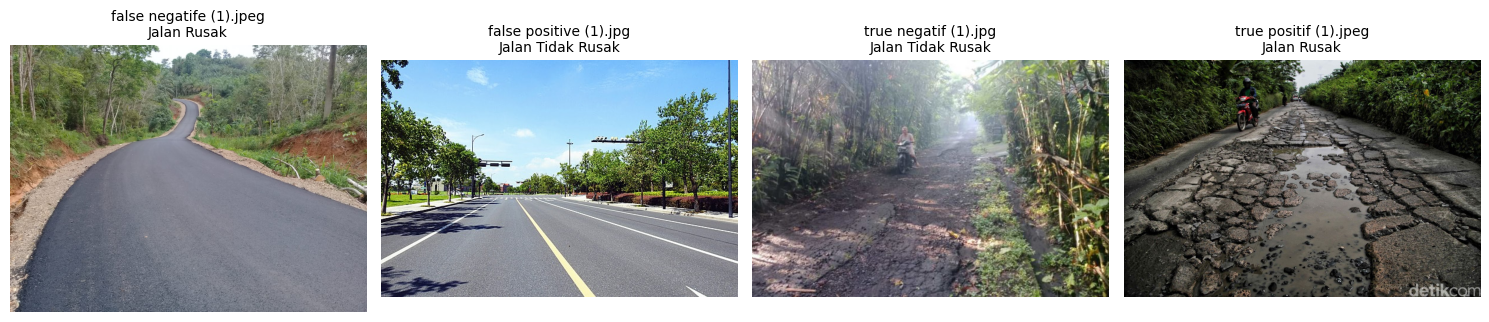

In [ ]:
import matplotlib.pyplot as plt

# Fungsi untuk preprocessing gambar tunggal
def preprocess_single_image(image_path, img_size=(128, 128)):
    img = cv2.imread(image_path)
    if img is not None:
        # Resize gambar ke ukuran img_size
        img = cv2.resize(img, img_size)
        # Flatten gambar menjadi vektor 1D
        img = img.flatten()
        # Normalisasi nilai pixel
        img = img / 255.0
        return img.reshape(-1, 1)  # Bentuknya (fitur x 1) agar sesuai input model
    else:
        print("Gambar tidak ditemukan.")
        return None

# Fungsi untuk mengklasifikasi gambar yang diunggah dan visualisasi
def classify_and_visualize_uploaded_images(parameters, img_size=(128, 128)):
    uploaded = files.upload()  # Memunculkan dialog upload
    uploaded_images = list(uploaded.keys())

    if len(uploaded_images) > 4:
        print("Hanya mendukung upload maksimal 4 gambar. Menggunakan 4 gambar pertama.")
        uploaded_images = uploaded_images[:4]

    predictions = []
    for file_name in uploaded_images:
        # Preprocess gambar
        img_vector = preprocess_single_image(file_name, img_size)
        if img_vector is not None:
            # Prediksi menggunakan model
            prediction = predict(img_vector, parameters)
            predictions.append((file_name, img_vector, prediction[0][0]))

    # Visualisasi hasil
    fig, axes = plt.subplots(1, len(predictions), figsize=(15, 5))
    if len(predictions) == 1:  # Jika hanya satu gambar, sesuaikan layout
        axes = [axes]

    for ax, (file_name, img_vector, prediction) in zip(axes, predictions):
        # Load ulang gambar untuk visualisasi
        img = cv2.imread(file_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Ubah ke format RGB untuk Matplotlib
        ax.imshow(img)
        ax.axis('off')
        label = "Jalan Rusak" if prediction == 1 else "Jalan Tidak Rusak"
        ax.set_title(f"{file_name}\n{label}", fontsize=10)

    plt.tight_layout()
    plt.show()

# Panggil fungsi klasifikasi
classify_and_visualize_uploaded_images(parameters)
